Do binary classification on the log1p(price per area) and split on the threshold.

Change log:
- Duplicate from exp-l16-binary.ipynb

### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


In [2]:
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from scipy import stats

In [3]:
model_name = 'metamodel-03-lgb-binary'

### Params

In [4]:
is_log_target = True
is_per_area_target = True
threshold_log_price_per_area = 13.45

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
#col_target = map_target[(is_log_target, is_per_area_target)]
col_target = 'price_group'

cols_num_add = ['building_per_land_area', 'height_r', 'top_floor']
cols_cat_add = ['encoded_latlon']

### Processing

In [5]:
def pre_processing(df, cols_num, cols_cat): #, cols_feats
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        
        # binary classfication target
        df['price_group'] = df['log_per_area_total_price'] > threshold_log_price_per_area
        
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['building_per_land_area'] = df['building_area'] / df['land_area']
 
    # fix town and city
    df['town'] = df['city'].astype('str')+'-'+df['town'].astype('str')
    df['village'] = df['town'].astype('str')+'-'+df['village'].astype('str')
    
    # height ratio
    df['height_r'] = df['txn_floor'] / df['total_floor']
    df['top_floor'] = df['txn_floor'] == df['total_floor']
    
    return df

In [6]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        #self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
    def fit_transform(self, df):
        df = df.copy()
    
#        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        self.cat_astyper.fit_transform(df, self.cols_cat)    
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        self.cat_astyper.transform(df)
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)


In [7]:
def post_processing(y_pred, df):
    """Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].values
        
    return y_pred_final

### Columns

In [8]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [9]:
train = pd.read_csv('dataset/train.csv', dtype=object)
test = pd.read_csv('dataset/test.csv', dtype=object)

id_cv = []
for i in range(5):
    id_one_fold = pd.read_csv(f'dataset/id_cv{i}.csv', dtype=object)['building_id']
    id_cv.append(id_one_fold)

### Preprocessing

In [10]:
train = pre_processing(train, cols_num, cols_cat)
test = pre_processing(test, cols_num, cols_cat)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [11]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats = cols_num + cols_cat

### Params

In [12]:
# params
params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric': ['binary_error'], # 'binary_error', 'auc', 'binary_logloss'
          'first_metric_only': True,
          'learning_rate': 0.005,
          'max_depth': 24,
          'num_leaves': 300,           # may reduce in dim-reduction exp
          'feature_fraction': 0.5,
          'min_data_in_leaf': 10,
          'lambda_l1': 0.01,
          'lambda_l2': 0.1,
         }

lgb_other_params = {'num_boost_round': 10000, # 50000
                    'verbose_eval': 200,  # 2000
                    'early_stopping_rounds': 1000,}


### kfold cross-predict

In [13]:
from collections import OrderedDict

In [14]:
t0 = time.time()

predicts_val = []
predicts_test = test[['building_id']].copy()
kfold_results = []  # store cv scores
for i, id_fold in enumerate(id_cv):
    # split train, val
    df_train = train.loc[~train['building_id'].isin(id_fold)].copy()
    df_val = train.loc[train['building_id'].isin(id_fold)].copy()
    df_test = test.copy()
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)
    df_test = feat_eng.transform(df_test)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_target], reference=lgb_train).construct()
        
    # train model    
    model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)
    best_iter = model.best_iteration

    # Predict on val set
    y_pred = model.predict(df_val[cols_feats])
    y_pred_final = y_pred >= 0.5
    acc = accuracy_score(df_val[col_target], y_pred_final)
    auc = roc_auc_score(df_val[col_target], y_pred)
    logloss = log_loss(df_val[col_target], y_pred)
    print('(Fold %d) acc, auc, logloss: %.5f, %.5f, %.5f at %d' % (i, acc, auc, logloss, best_iter))
    kfold_results.append(OrderedDict(fold=i, acc=acc, auc=auc, logloss=logloss, best_iter=best_iter))

    predicts_val.append(pd.DataFrame({'building_id': df_val['building_id'],
                                      'price_group': df_val['price_group'],
                                      'price_group_pred': y_pred_final}))

    # Predict on test set
    y_pred_test = model.predict(df_test[cols_feats])
    y_pred_test_final = y_pred_test >= 0.5
    predicts_test['price_group_pred_{}'.format(i)] = y_pred_test_final
kfold_results = pd.DataFrame(kfold_results)

Training until validation scores don't improve for 1000 rounds.
[200]	valid_0's binary_error: 0.0504167
[400]	valid_0's binary_error: 0.0465
[600]	valid_0's binary_error: 0.0440833
[800]	valid_0's binary_error: 0.04275
[1000]	valid_0's binary_error: 0.0416667
[1200]	valid_0's binary_error: 0.0415833
[1400]	valid_0's binary_error: 0.0413333
[1600]	valid_0's binary_error: 0.04125
[1800]	valid_0's binary_error: 0.041
[2000]	valid_0's binary_error: 0.04075
[2200]	valid_0's binary_error: 0.0409167
[2400]	valid_0's binary_error: 0.0405833
[2600]	valid_0's binary_error: 0.041
[2800]	valid_0's binary_error: 0.0411667
Early stopping, best iteration is:
[1888]	valid_0's binary_error: 0.0405
(Fold 0) acc, auc, logloss: 0.95950, 0.99252, 0.11407 at 1888
Training until validation scores don't improve for 1000 rounds.
[200]	valid_0's binary_error: 0.0518333
[400]	valid_0's binary_error: 0.0474167
[600]	valid_0's binary_error: 0.0445833
[800]	valid_0's binary_error: 0.0425833
[1000]	valid_0's binary_

In [15]:
print('Total run time:', time.time() - t0)

Total run time: 611.7476050853729


In [16]:
display(kfold_results)

,fold,acc,auc,logloss,best_iter
0,0,0.959500,0.992516,0.114066,1888
1,1,0.959000,0.991645,0.113968,1170
2,2,0.957250,0.992324,0.124764,2463
3,3,0.957667,0.992816,0.149345,4560
4,4,0.961250,0.992650,0.111800,1876


In [17]:
for m, m_name in zip(['acc', 'auc', 'logloss', 'best_iter'], 
                     ['accuracy', 'AUC', 'log loss', 'best iteration']):
    print('Kfold cv', m_name, '(mean, stdev):', np.mean(kfold_results[m]), np.std(kfold_results[m]))

Kfold cv accuracy (mean, stdev): 0.9589333333333332 0.0014234152981864182
Kfold cv AUC (mean, stdev): 0.9923901407523532 0.0004061092239830668
Kfold cv log loss (mean, stdev): 0.12278866043991807 0.014027124868712895
Kfold cv best iteration (mean, stdev): 2391.4 1159.2082815439167


In [18]:
# CV set combine
df_predicts_val = pd.concat(predicts_val, axis=0)
df_predicts_val['price_group'] = df_predicts_val['price_group'].astype('int32')
df_predicts_val['price_group_pred'] = df_predicts_val['price_group_pred'].astype('int32')
df_predicts_val.check()

,building_id,price_group,price_group_pred
3,jre1pJhcQj91Kdky,1,1
10,jcbuA8q3KPH9SzpS,0,0
13,EqWJpHmkXPyfHkB8,1,1
14,ihrMWGM8Nq99Uvu6,1,1
16,jRhwzoVMFLFzxAX1,1,1
59987,QZSvDBvS2WqfYPDl,1,1
59989,JjHLg8Nh6k4Tbdci,1,1
59996,PiOgZqfsDVlTq1zs,1,1
59997,FQmlgGohzzWuKUzu,1,1
59998,zjzfMwXhDswdEaI2,1,1


shape = (60000, 3)


In [19]:
df_predicts_val.to_csv('output/'+model_name+'-cv.csv', index=False)

In [20]:
# Test set combine
for i in range(len(id_cv)):
    predicts_test['price_group_pred_'+str(i)] = predicts_test['price_group_pred_'+str(i)].astype('int32')
predicts_test['price_group_pred'] = (
    stats.mode(predicts_test[['price_group_pred_'+str(i) for i in range(len(id_cv))]], axis=1)[0]
)

In [21]:
predicts_test.check()

,building_id,price_group_pred_0,price_group_pred_1,price_group_pred_2,price_group_pred_3,price_group_pred_4,price_group_pred
0,X5gsdTWGS3W7JJQB,1,1,1,1,1,1
1,BTshNOJyKHnT2YIT,0,0,0,0,0,0
2,dhdymr0lV8N5kZOT,1,1,1,1,1,1
3,VEwyGGMcD56w5BOc,1,1,1,1,1,1
4,wmUeMoJZfsqaSX9b,0,0,0,0,0,0
9995,UEeCDaAJzPwdKKKA,0,0,0,0,0,0
9996,i0fgbPaQsDWs7Q87,1,1,1,1,1,1
9997,YunNwAhcqkf6YclI,0,0,0,0,0,0
9998,A2NotxtRY9MYoWMl,1,1,1,1,1,1
9999,kKvgBXiA50gRmQhP,0,0,0,0,0,0


shape = (10000, 7)


In [22]:
predicts_test.to_csv('output/'+model_name+'-test-kfold.csv', index=False)

### One-fold prediction

In [23]:
best_iterations = kfold_results['best_iter']

In [24]:
lgb_other_params_one = {'num_boost_round': int(np.mean(best_iterations)*1.15),
                        'verbose_eval': 200,}
lgb_other_params_one

{'num_boost_round': 2750, 'verbose_eval': 200}

In [25]:
params

{'task': 'train',
 'boosting_type': 'gbdt',
 'objective': 'binary',
 'metric': ['binary_error'],
 'first_metric_only': True,
 'learning_rate': 0.005,
 'max_depth': 24,
 'num_leaves': 300,
 'feature_fraction': 0.5,
 'min_data_in_leaf': 10,
 'lambda_l1': 0.01,
 'lambda_l2': 0.1}

In [26]:
df_train = train.copy()
df_test = test.copy()

# feat eng
feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
df_train = feat_eng.fit_transform(df_train)
df_test = feat_eng.transform(df_test)

# Construct lgb dataset
lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()

# train model    
model = lgb.train(params, lgb_train, valid_sets=lgb_train, **lgb_other_params_one)

y_pred = model.predict(df_test[cols_feats])
y_pred_final = (y_pred >= 0.5).astype('int32')

df_test_pred = pd.DataFrame({'building_id': df_test['building_id'], 
                             'price_group_pred': y_pred_final})
df_test_pred.check()

[200]	training's binary_error: 0.0296167
[400]	training's binary_error: 0.0218
[600]	training's binary_error: 0.0150333
[800]	training's binary_error: 0.0093
[1000]	training's binary_error: 0.0046
[1200]	training's binary_error: 0.00163333
[1400]	training's binary_error: 0.000533333
[1600]	training's binary_error: 0.000266667
[1800]	training's binary_error: 0.0001
[2000]	training's binary_error: 5e-05
[2200]	training's binary_error: 1.66667e-05
[2400]	training's binary_error: 1.66667e-05
[2600]	training's binary_error: 1.66667e-05


,building_id,price_group_pred
0,X5gsdTWGS3W7JJQB,1
1,BTshNOJyKHnT2YIT,0
2,dhdymr0lV8N5kZOT,1
3,VEwyGGMcD56w5BOc,1
4,wmUeMoJZfsqaSX9b,0
9995,UEeCDaAJzPwdKKKA,0
9996,i0fgbPaQsDWs7Q87,1
9997,YunNwAhcqkf6YclI,0
9998,A2NotxtRY9MYoWMl,1
9999,kKvgBXiA50gRmQhP,0


shape = (10000, 2)


In [27]:
df_test_pred.to_csv('output/'+model_name+'-test-one.csv', index=False)

### Feature importance

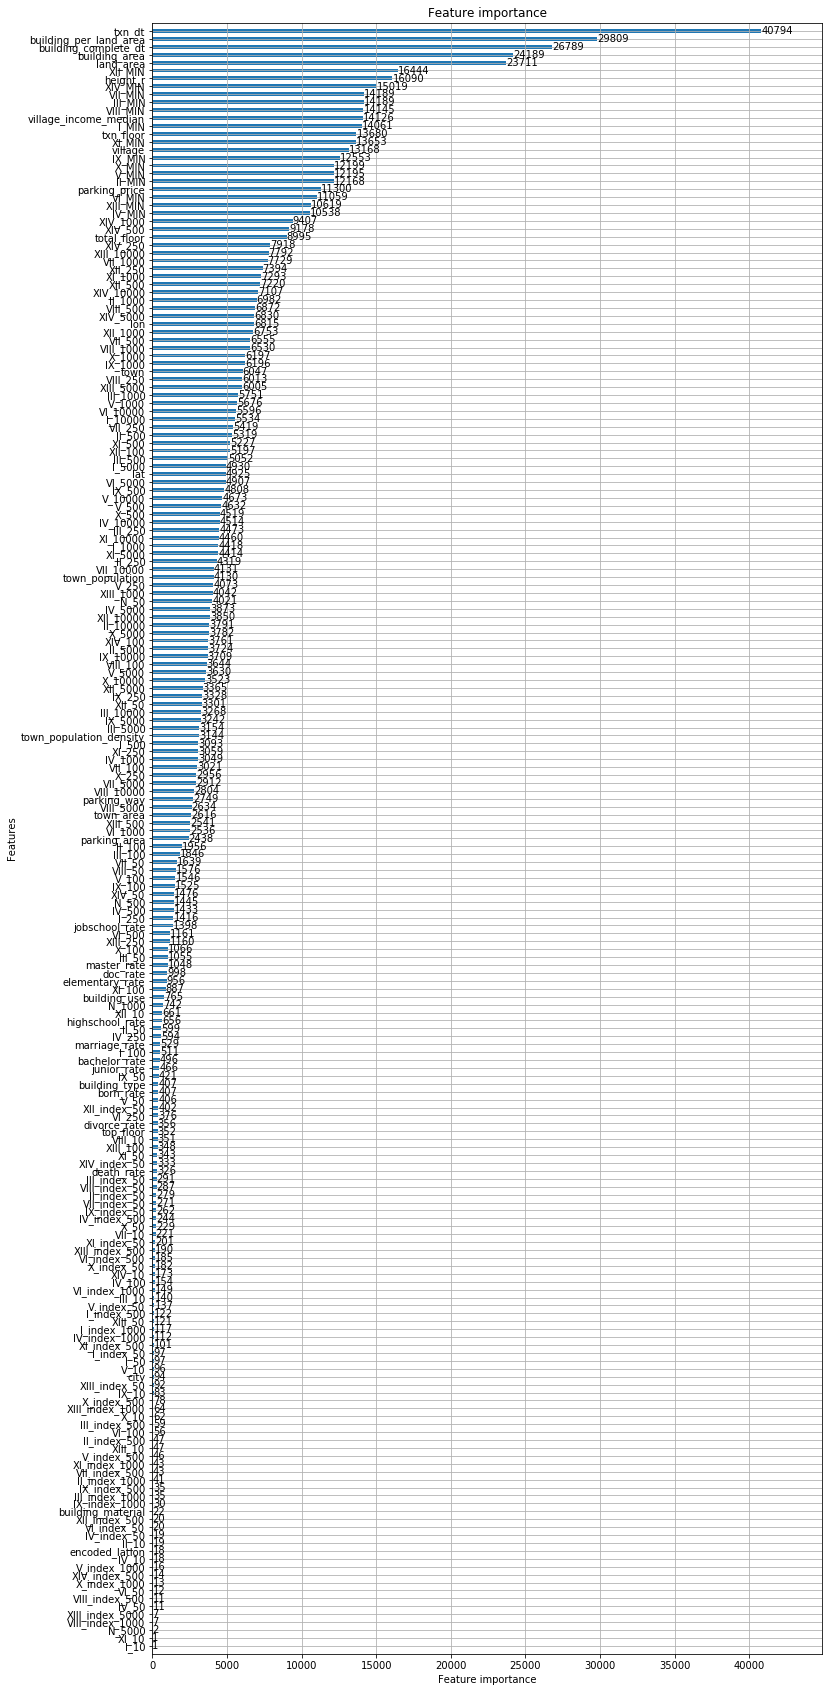

In [28]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

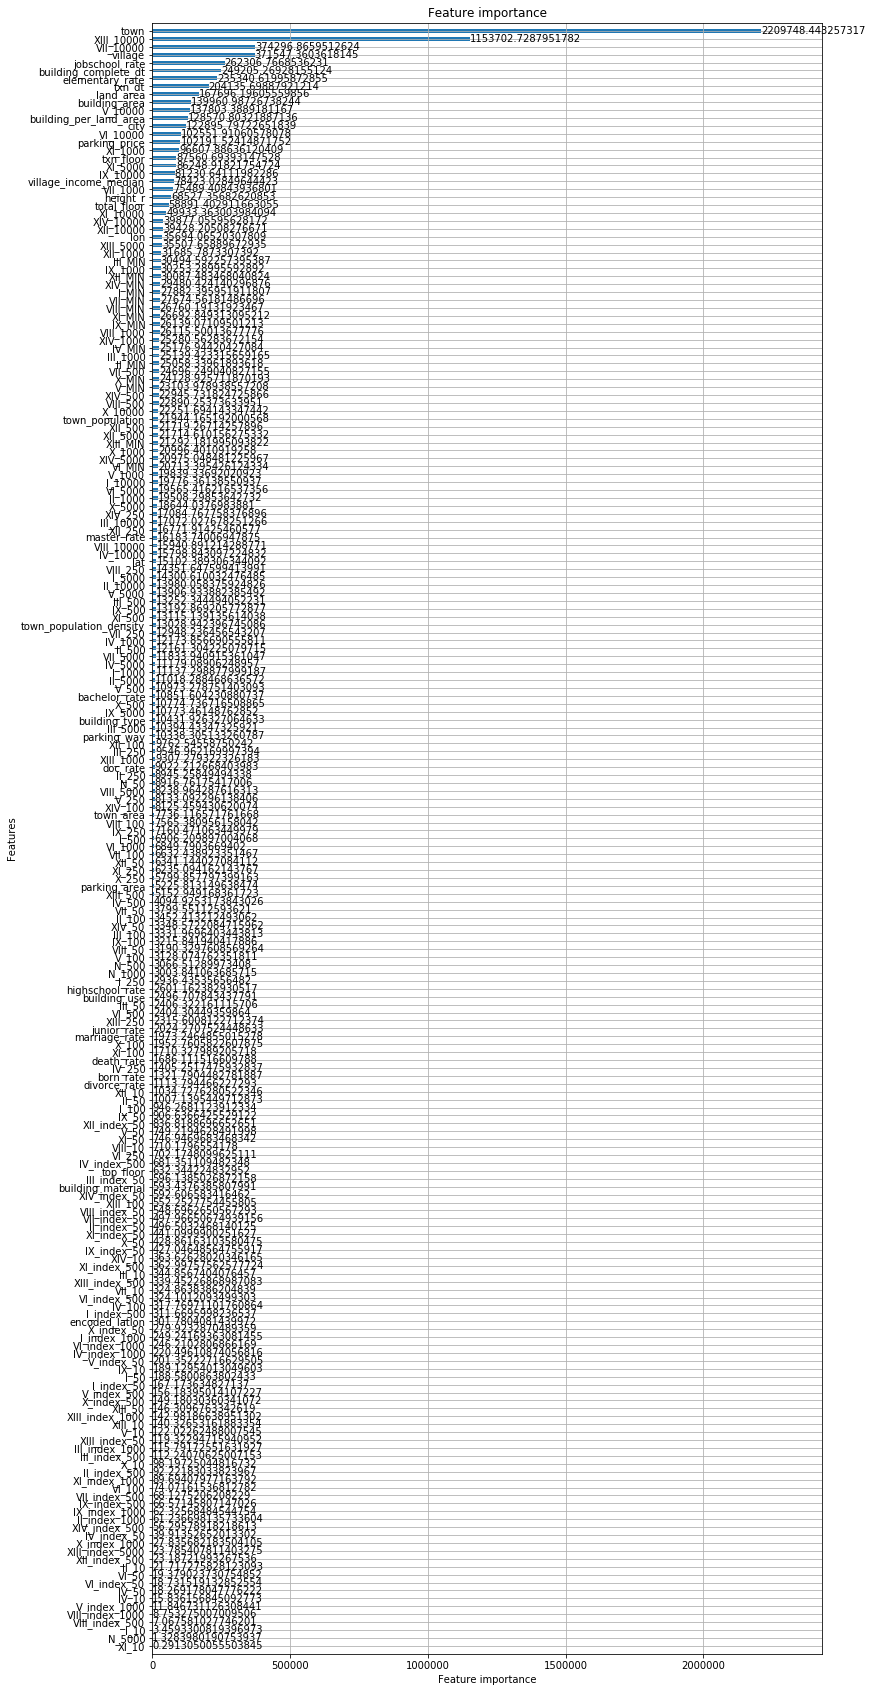

In [29]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()